In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/brain-tumor-dataset-segmentation-and-classification
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Pituitary tumor
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Meningioma
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation/Glioma
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training/pituitary
/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training/notumor
/kaggle/input/brain-tumor-dataset-segmentation-and-classificati

# lets wrap our heads a litle :
so there is two main folders one for Classification and other for Segmentation
1. *Classification folder* : /kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification
2. *Segmentation folder* : /kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/Segmentation


# Classification comes first 

## Folders to dataset convert first

In [2]:
import tensorflow as tf

BATCH_SIZE = 8
IMG_SIZE = (380, 380)  

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Testing',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names

2025-06-11 13:40:30.401013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749649230.592544     448 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749649230.645005     448 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5712 files belonging to 4 classes.


I0000 00:00:1749649239.197633     448 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1311 files belonging to 4 classes.


In [3]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the model and Data Augminting

In [4]:
from tensorflow.keras.applications import EfficientNetB5

base_model = EfficientNetB5(
    weights='imagenet',
    input_shape=(380, 380, 3),
    include_top=False
)
base_model.trainable = False  # Freeze base model

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

inputs = tf.keras.layers.Input(shape=(380, 380, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='pooling')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

final_model = tf.keras.models.Model(inputs, outputs)

final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 380, 380, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 380, 380, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb5 (Functional)          │ (None, 12, 12, 2048)        │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling (GlobalAveragePooling2D)     │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,615,803 (116.79 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 28,513,527 (108.77 MB)

## Staged Training 

### Stage 1

In [5]:
from tensorflow.keras import callbacks

# Define callbacks
callbacks = [
    # Early Stopping
    callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=6,             
        restore_best_weights=True,  
        verbose=1
    ),
    
    # Learning Rate Reduction
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',      
        factor=0.5,              
        patience=3,              
        min_lr=1e-7,             
        verbose=1
    )
]

In [6]:
# 1. Keep base model frozen
base_model.trainable = False

# 2. Compile with higher initial LR
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. First training phase
history_frozen = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45,
    callbacks=callbacks,  # Use the callbacks you defined earlier
    verbose=1
)

Epoch 1/45


E0000 00:00:1749649280.304309     448 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb5_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1749649282.852852     485 cuda_dnn.cc:529] Loaded cuDNN version 90300


714/714 ━━━━━━━━━━━━━━━━━━━━ 165s 177ms/step - accuracy: 0.7619 - loss: 0.6088 - val_accuracy: 0.7986 - val_loss: 0.4795 - learning_rate: 0.0010
Epoch 2/45
714/714 ━━━━━━━━━━━━━━━━━━━━ 102s 143ms/step - accuracy: 0.8713 - loss: 0.3379 - val_accuracy: 0.8299 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 3/45
714/714 ━━━━━━━━━━━━━━━━━━━━ 103s 144ms/step - accuracy: 0.8845 - loss: 0.2882 - val_accuracy: 0.8535 - val_loss: 0.3703 - learning_rate: 0.0010
Epoch 4/45
714/714 ━━━━━━━━━━━━━━━━━━━━ 102s 143ms/step - accuracy: 0.9019 - loss: 0.2610 - val_accuracy: 0.9062 - val_loss: 0.2453 - learning_rate: 0.0010
Epoch 5/45
714/714 ━━━━━━━━━━━━━━━━━━━━ 102s 143ms/step - accuracy: 0.9105 - loss: 0.2375 - val_accuracy: 0.8734 - val_loss: 0.3343 - learning_rate: 0.0010
Epoch 6/45
714/714 ━━━━━━━━━━━━━━━━━━━━ 102s 143ms/step - accuracy: 0.9141 - loss: 0.2228 - val_accuracy: 0.8841 - val_loss: 0.3041 - learning_rate: 0.0010
Epoch 7/45
714/714 ━━━━━━━━━━━━━━━━━━━━ 103s 144ms/step - accuracy: 0.9180 

### Stage 2

In [7]:
# 1. unfreez the last 100 layer
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False  

# 2. Recompile with lower LR
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Fine-tune callbacks (more aggressive)
fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Shorter patience for fine-tuning
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # More gentle LR reduction
        patience=2,
        min_lr=1e-7
    )
]

# 4. Second training phase
history_fine_tune = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,  
    initial_epoch=history_frozen.epoch[-1] + 1,  
    callbacks=fine_tune_callbacks,
    verbose=1
)

Epoch 26/60


E0000 00:00:1749652051.068064     448 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb5_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


714/714 ━━━━━━━━━━━━━━━━━━━━ 439s 437ms/step - accuracy: 0.8153 - loss: 0.7738 - val_accuracy: 0.9314 - val_loss: 0.2096 - learning_rate: 1.0000e-04
Epoch 27/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 302s 424ms/step - accuracy: 0.9371 - loss: 0.1752 - val_accuracy: 0.9695 - val_loss: 0.0994 - learning_rate: 1.0000e-04
Epoch 28/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 303s 424ms/step - accuracy: 0.9587 - loss: 0.1236 - val_accuracy: 0.9748 - val_loss: 0.0813 - learning_rate: 1.0000e-04
Epoch 29/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 302s 423ms/step - accuracy: 0.9728 - loss: 0.0805 - val_accuracy: 0.9748 - val_loss: 0.0655 - learning_rate: 1.0000e-04
Epoch 30/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 302s 423ms/step - accuracy: 0.9828 - loss: 0.0624 - val_accuracy: 0.9802 - val_loss: 0.0752 - learning_rate: 1.0000e-04
Epoch 31/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 302s 423ms/step - accuracy: 0.9751 - loss: 0.0635 - val_accuracy: 0.9756 - val_loss: 0.1084 - learning_rate: 1.0000e-04
Epoch 32/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 303s 

# Evaluation and Plots

## Plot the history

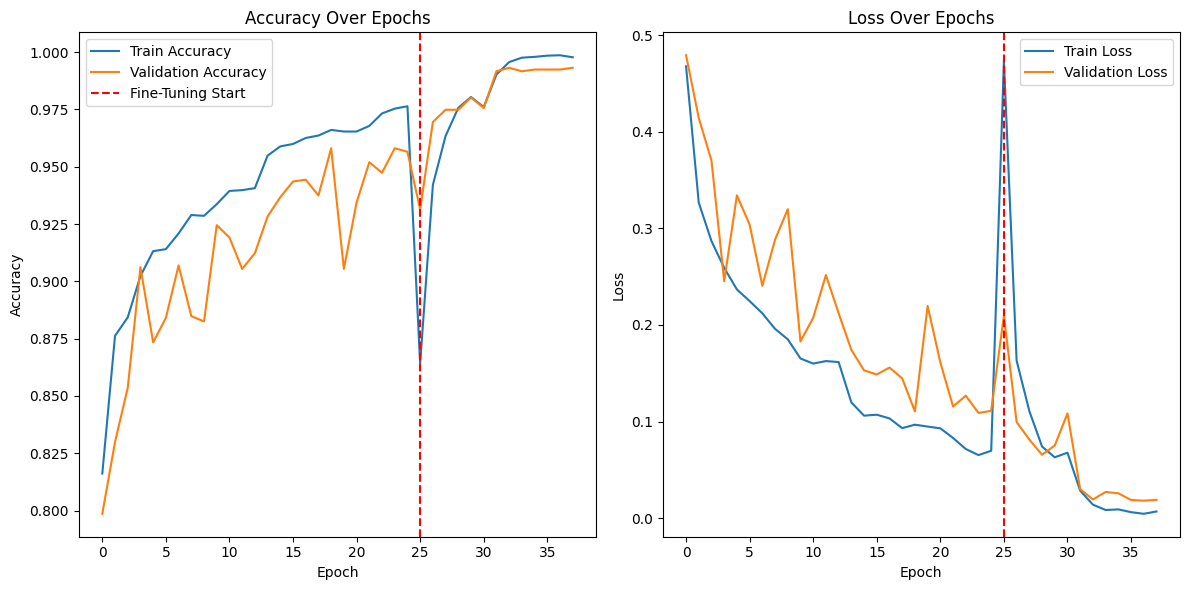

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history_frozen, history_fine_tune=None):
    plt.figure(figsize=(12, 6))
    
    # Combine histories if fine-tuning was done
    if history_fine_tune:
        for key in history_frozen.history:
            history_frozen.history[key] += history_fine_tune.history[key]
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_frozen.history['accuracy'], label='Train Accuracy')
    plt.plot(history_frozen.history['val_accuracy'], label='Validation Accuracy')
    if history_fine_tune:
        plt.axvline(len(history_frozen.history['accuracy']) - len(history_fine_tune.history['accuracy']), 
                   color='red', linestyle='--', label='Fine-Tuning Start')
    plt.title('Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_frozen.history['loss'], label='Train Loss')
    plt.plot(history_frozen.history['val_loss'], label='Validation Loss')
    if history_fine_tune:
        plt.axvline(len(history_frozen.history['loss']) - len(history_fine_tune.history['loss']), 
                   color='red', linestyle='--')
    plt.title('Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot both phases
plot_training_history(history_frozen, history_fine_tune)

## Classification report 

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred_probs = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(final_model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Check if labels are one-hot encoded
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(
    y_true,
    y_pred,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9867    0.9933       300
           1     0.9870    0.9902    0.9886       306
           2     1.0000    0.9975    0.9988       405
           3     0.9836    0.9967    0.9901       300

    accuracy                         0.9931      1311
   macro avg     0.9926    0.9928    0.9927      1311
weighted avg     0.9932    0.9931    0.9931      1311



## Confusion Matrix

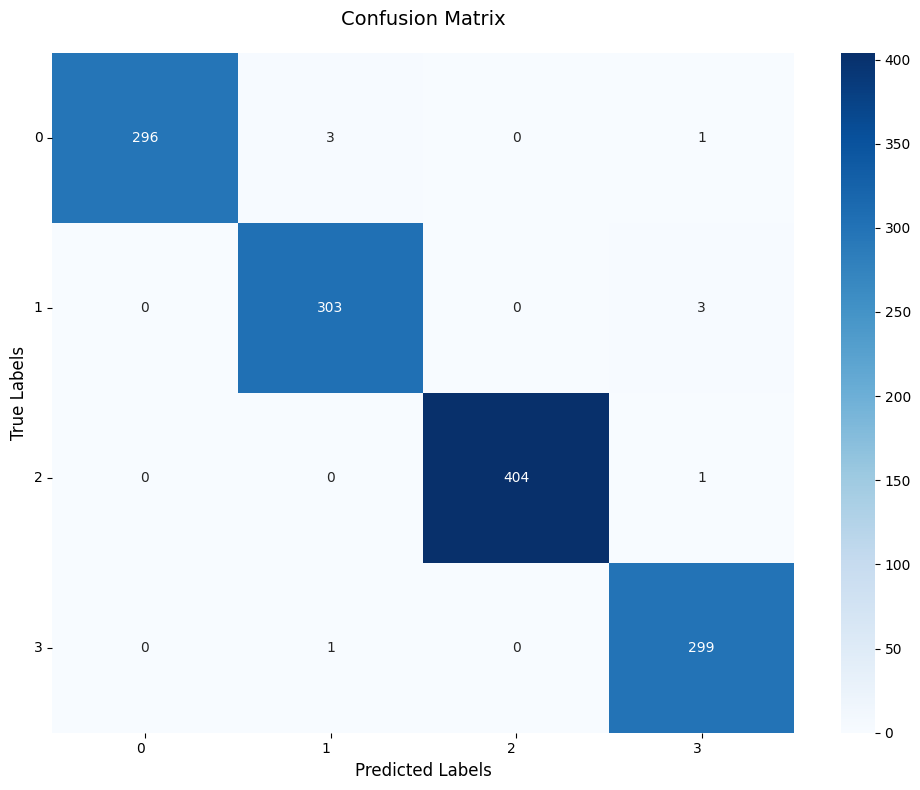

In [11]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a beautiful confusion matrix with annotations
    
    Args:
        y_true: Array of true labels
        y_pred: Array of predicted labels
        class_names: List of class names
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',)
    
    # Add labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, pad=20)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Usage with your TensorFlow dataset
# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    # Get true labels (convert from one-hot if needed)
    if len(labels.shape) > 1:  # If one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())
    
    # Get predictions
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))


plot_confusion_matrix(y_true, y_pred, )

## TSNE

In [12]:
from sklearn.manifold import TSNE

# Create embedding model (remove classification head)
embedding_model = tf.keras.Model(
    inputs=final_model.inputs,
    outputs=final_model.get_layer('pooling').output  # Use your GAP layer name
)

# Get embeddings and labels
embeddings, labels = [], []
for images, lbls in val_ds.take(50):  # Use subset for faster processing
    emb = embedding_model.predict(images, verbose=0)
    embeddings.append(emb)
    labels.append(lbls.numpy())

embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_577']
Received: inputs=Tensor(shape=(8, 380, 380, 3))
  warnings.warn(msg)


In [13]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

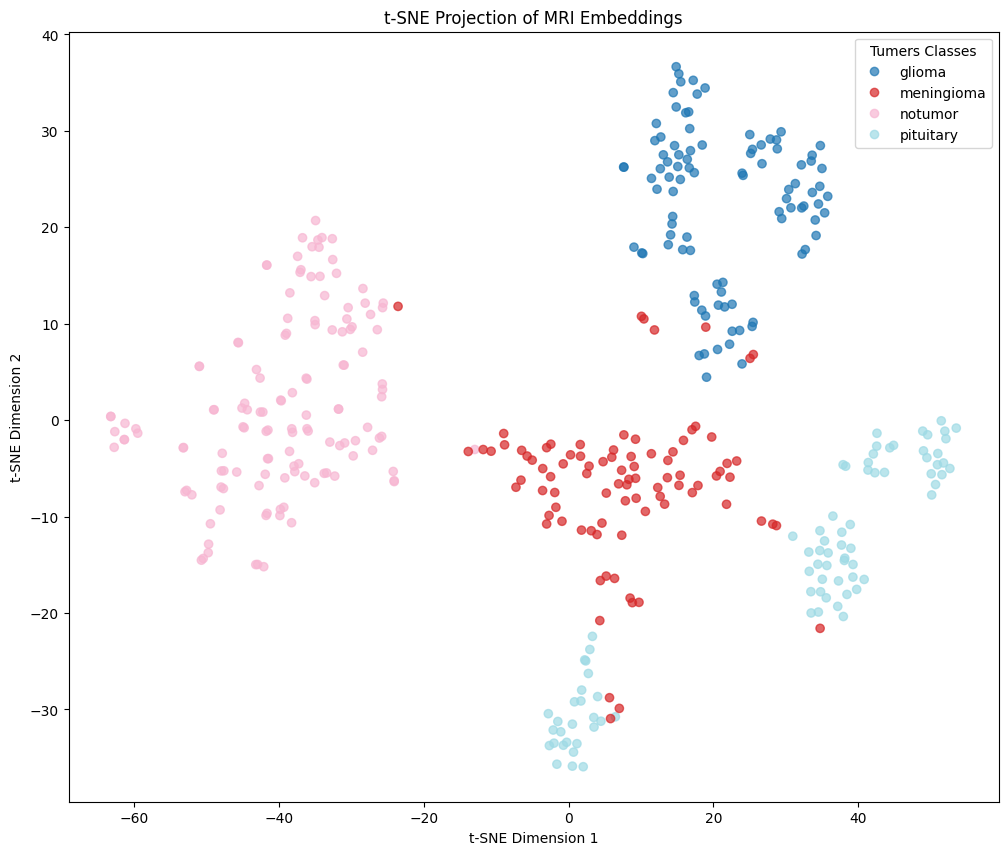

In [14]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=labels,
    cmap='tab20',
    alpha=0.7
)

# Add legend and labels
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=class_names,
    title="Tumers Classes"
)
plt.title("t-SNE Projection of MRI Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Show some Examples

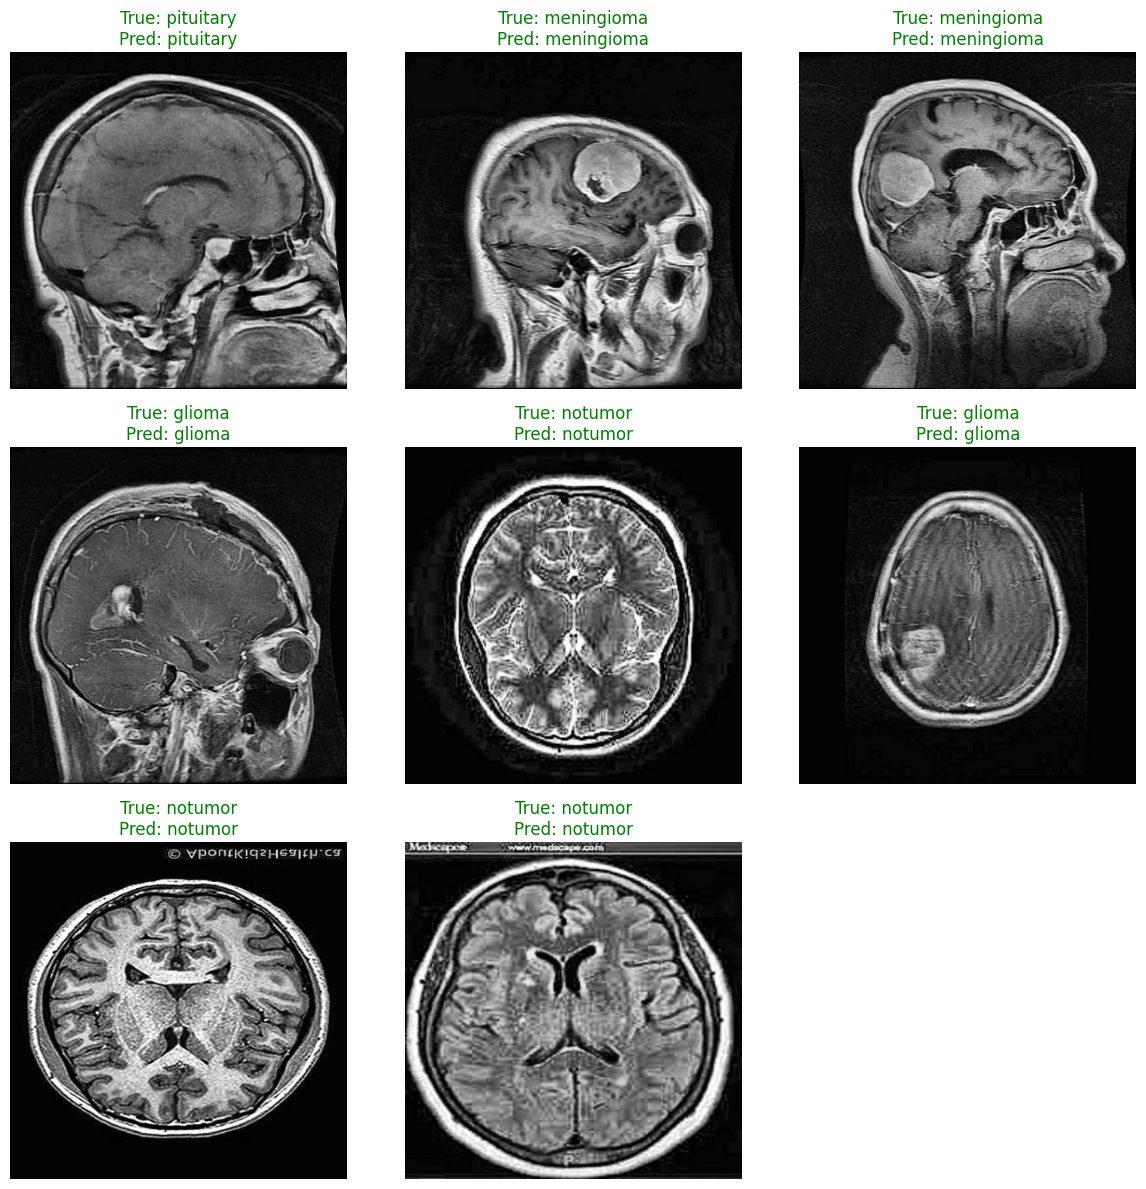

In [20]:
def plot_predictions(model, dataset, class_names, num_images=9):
    """
    Plots images with their true and predicted labels
    
    Args:
        model: Trained Keras model
        dataset: TensorFlow dataset (batched)
        class_names: List of class names
        num_images: Number of images to display (default 9)
    """
    plt.figure(figsize=(12, 12))
    
    # Take one batch from the dataset
    for images, labels in dataset.take(2):
        # Make predictions
        preds = final_model.predict(images, verbose=0)
        pred_classes = np.argmax(preds, axis=1)
        
        # Convert one-hot labels if needed
        if len(labels.shape) > 1:
            true_classes = np.argmax(labels.numpy(), axis=1)
        else:
            true_classes = labels.numpy()
        
        # Plot images
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Set title with color coding
            true_label = class_names[true_classes[i]]
            pred_label = class_names[pred_classes[i]]
            
            color = 'green' if true_label == pred_label else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Usage
plot_predictions(final_model, val_ds, class_names)

# Segmentation Coming next